<a href="https://www.kaggle.com/code/deepakvk18/super-market-customers-clustering?scriptVersionId=102509624" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Problem Statement

You are owing a supermarket mall and through membership cards, you have some basic data about your customers like Customer ID, age, gender, annual income and spending score. You want to understand the customers like who are the target customers so that the sense can be given to marketing team and plan the strategy accordingly.

[You can download the dataset from here.](https://www.kaggle.com/datasets/dev0914sharma/customer-clustering)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-clustering/segmentation data.csv
/kaggle/input/customer-clustering/segmentation data legend.xlsx


In [2]:
! pip install pyclustertend

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, classification_report
from pyclustertend import hopkins,vat
import scipy.cluster.hierarchy as sch
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer

In [4]:
plt.style.use('fivethirtyeight')

In [5]:
data = pd.read_csv('/kaggle/input/customer-clustering/segmentation data.csv')
data.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


In [6]:
data.shape

(2000, 8)

### Features in dataset

**ID** - Shows a unique identificator of a customer.	
				
**Sex** -  Biological sex (gender) of a customer. In this dataset there are only 2 different options.	
		0	male	
		1	female	
				
**Marital status**- Marital status of a customer.	
		0	single	
		1	non-single (divorced / separated / married / widowed)	
				
**Age** - The age of the customer in years, calculated as current year minus the year of birth of the customer at the time of creation of the dataset	
		18	Min value (the lowest age observed in the dataset)	
		76	Max value (the highest age observed in the dataset)	
				
**Education** - Level of education of the customer	
		0	other / unknown	
		1	high school	
		2	university	
		3	graduate school	
				
**Income** - Self-reported annual income in US dollars of the customer.	
		35832	Min value (the lowest income observed in the dataset)	
		309364	Max value (the highest income observed in the dataset)	
				
**Occupation** - Category of occupation of the customer.	
		0	unemployed / unskilled	
		1	skilled employee / official	
		2	management / self-employed / highly qualified employee / officer	
				
**Settlement size** - The size of the city that the customer lives in.	
		0	small city	
		1	mid-sized city	
		2	big city	

# Exploratory Data Analysis

In [7]:
eda = data.copy()

In [8]:
cat = ['Sex', 'Marital status', 'Education', 'Occupation','Settlement size']
num = ['Age','Income']

In [9]:
eda.Sex.replace({0:'male',1:'female'}, inplace=True)
eda.Education.replace({0 :'other / unknown',1: 'high school',2: 'university',3: 'graduate school'}, inplace=True)
eda['Marital status'].replace({0 :'single',1 :'non-single'}, inplace=True)
eda.Occupation.replace({0 :'unemployed',1: 'official',2: 'management / self-employed'}, inplace=True)
eda['Settlement size'].replace({0: 'small city',1: 'mid-sized city',2: 'big city'}, inplace=True)

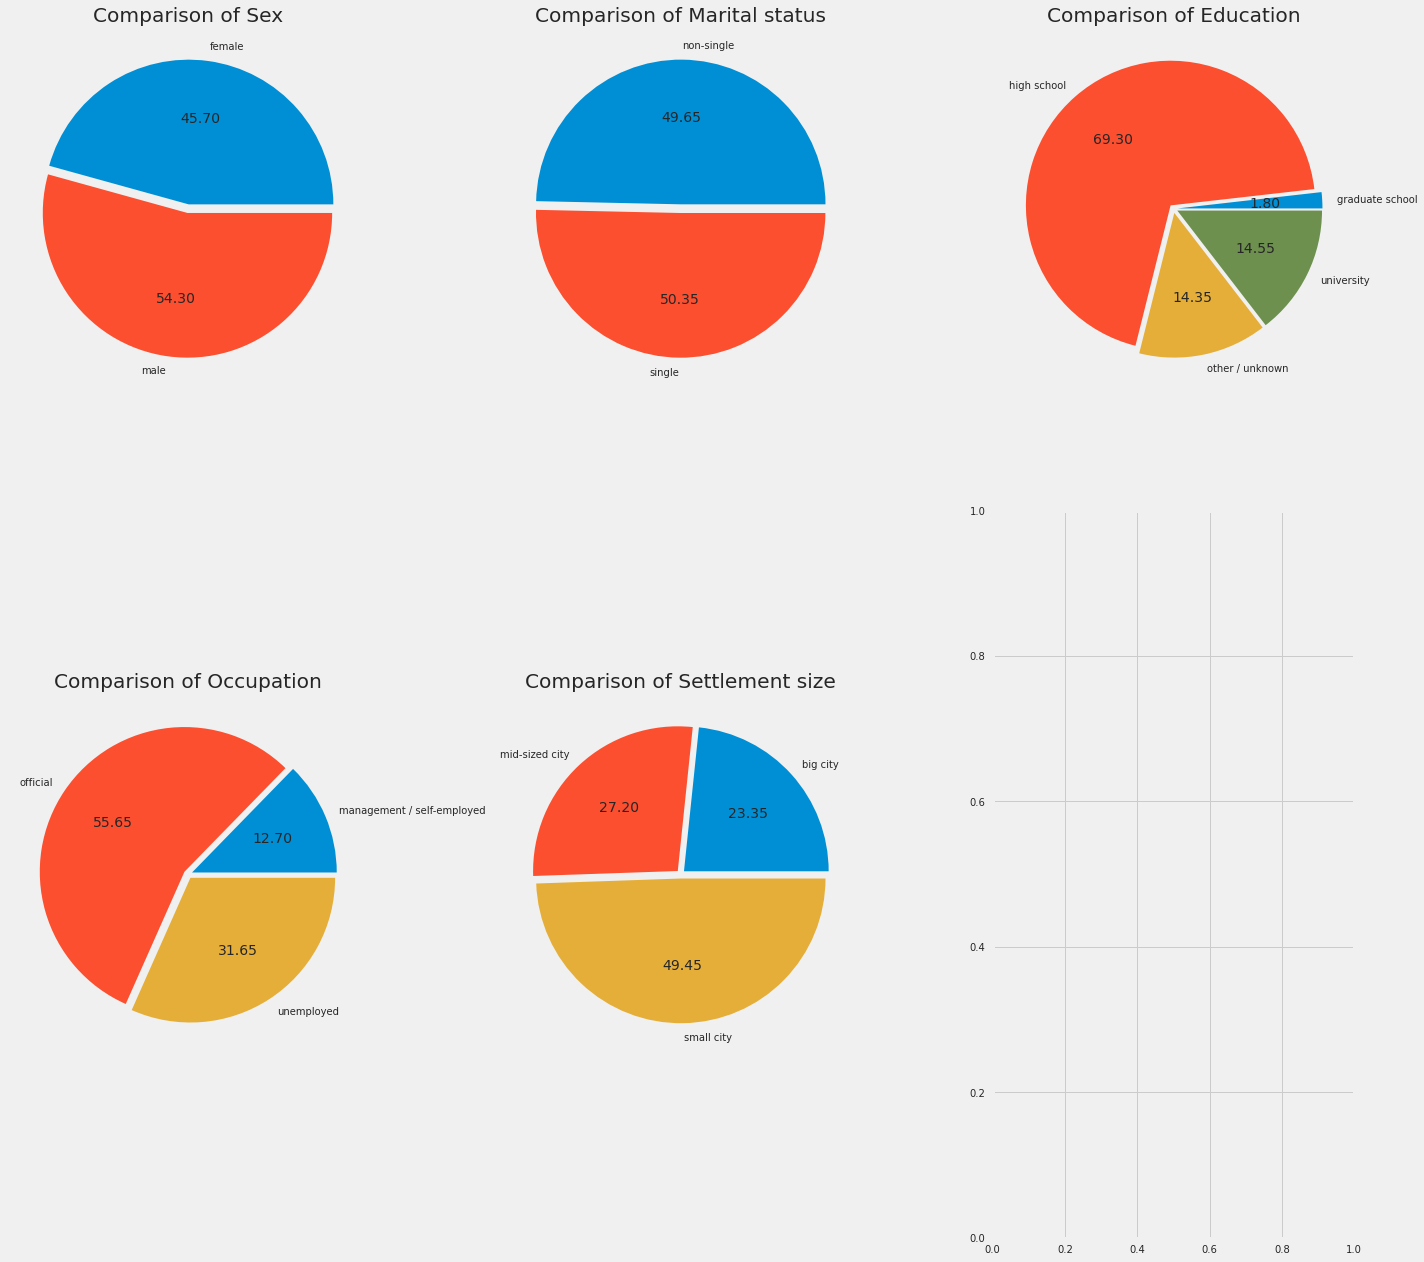

In [10]:
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(20,20))
i,j = 0,0
k = 0
for i in range(2):
    for j in range(3):
        df = eda.groupby(by=cat[k]).count()
        ax[i,j].title.set_text("Comparison of "+cat[k])
        ax[i,j].pie(data=df, labels=df.index ,x= 'ID',autopct='%.2f', explode=[0.03]*len(df.index));
        j += 1
        k += 1
        if k == len(cat):
            break
    i+=1
plt.tight_layout()

The distribution of male, female & married,unmarried are fairly the same. Most of the people stop education at high school and very few go to university and even fewer go to graduate schools. 

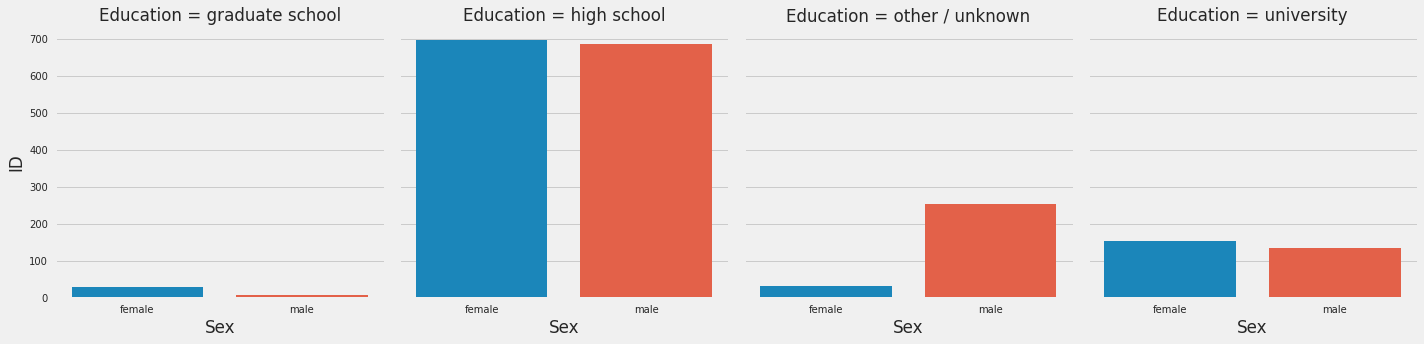

In [11]:
df = eda.groupby(by=['Sex','Education']).count().reset_index()
sns.catplot(data=df,col='Education',x='Sex',y='ID',kind='bar');

Most people whose education background is unknown are male. Most people who go to university and graduate schools are female.

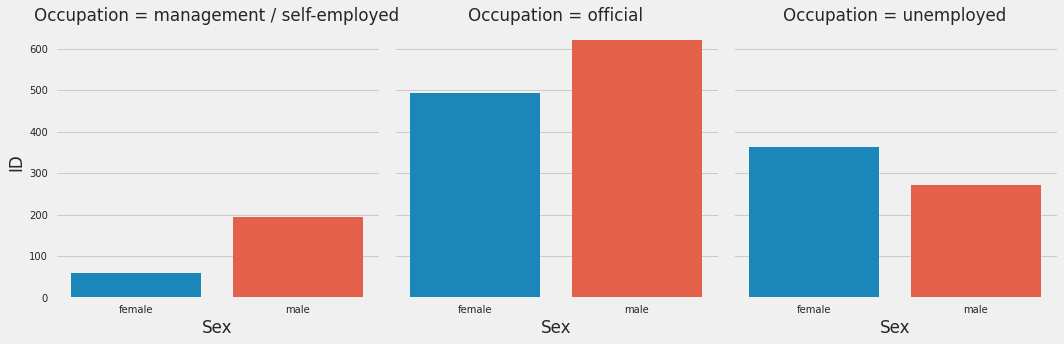

In [12]:
df = eda.groupby(by=['Sex','Occupation']).count().reset_index()
sns.catplot(data=df,col='Occupation',x='Sex',y='ID',kind='bar');

Most people who are managers or self employed are males and most people who are employed are also male. Most people who are unemployes are female eventhough females are the ones to pursue higher education after high school.

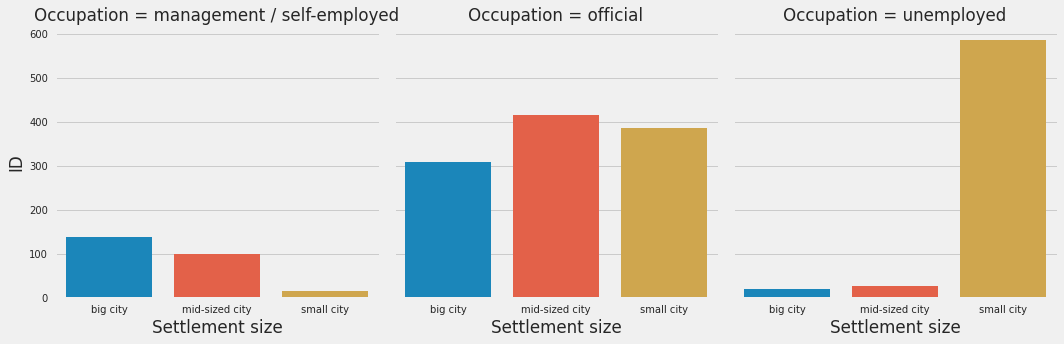

In [13]:
df = eda.groupby(by=['Settlement size','Occupation']).count().reset_index()
sns.catplot(data=df,col='Occupation',x='Settlement size',y='ID',kind='bar');

People who are unemployed mostly live in small cities and only a few people live in big cities.

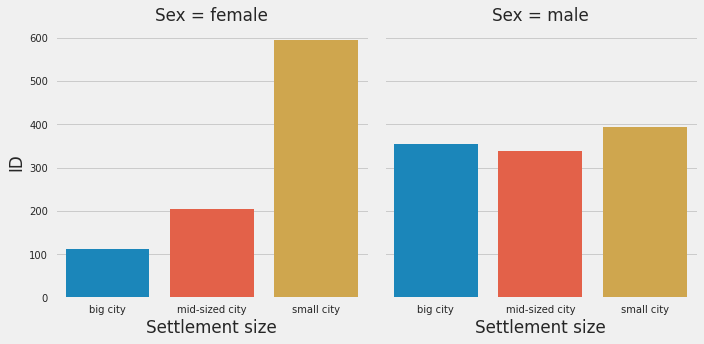

In [14]:
df = eda.groupby(by=['Settlement size','Sex']).count().reset_index()
sns.catplot(data=df,col='Sex',x='Settlement size',y='ID',kind='bar');

Least number of females live in big city and the most live in small cities. 

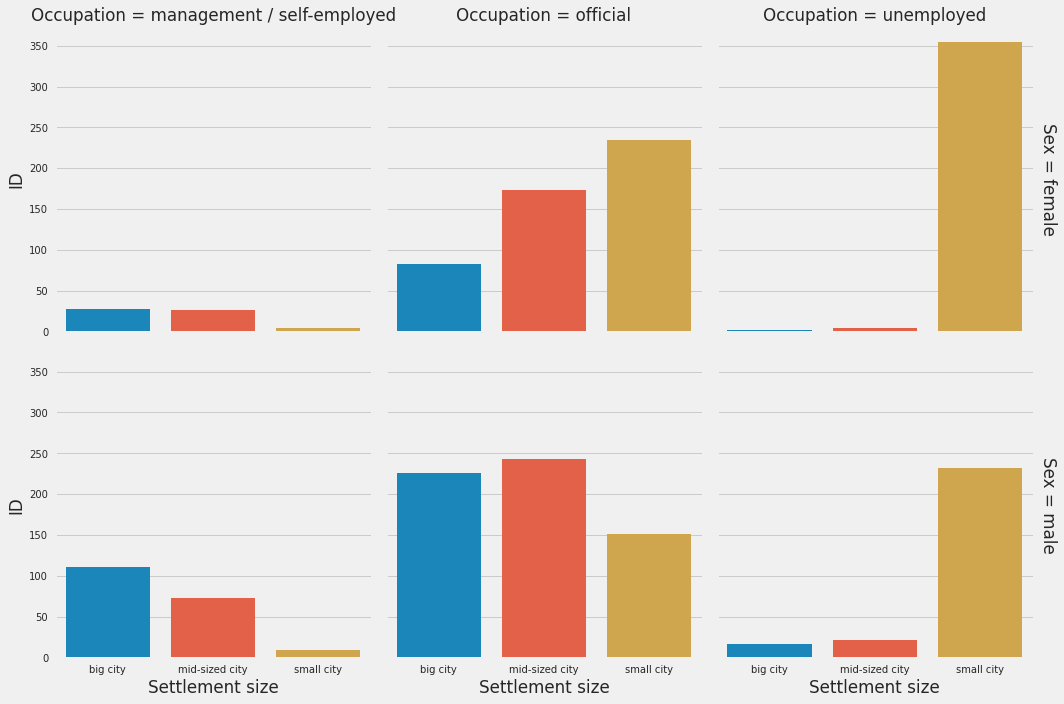

In [15]:
df = eda.groupby(by=['Sex','Settlement size','Occupation']).count().reset_index()
sns.catplot(data=df,row='Sex',col='Occupation',x='Settlement size',y='ID',kind='bar',margin_titles=True);
plt.tight_layout()

Females who live in small cities are mostly unemployed and only a few self-employed live in small cities.

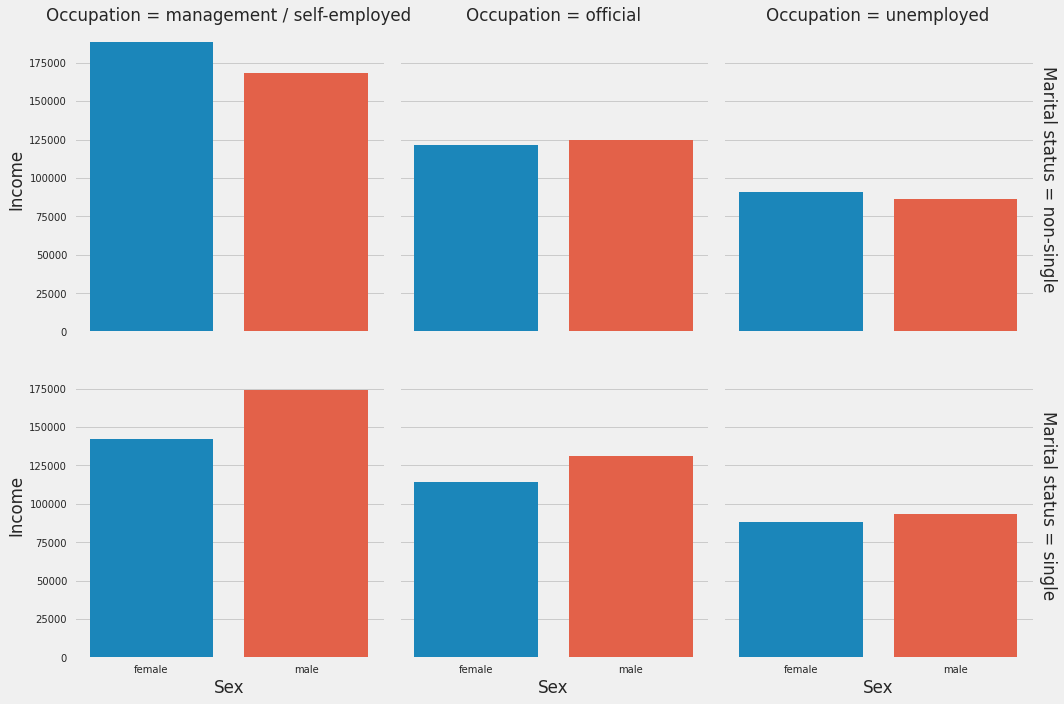

In [16]:
df = eda.groupby(by=['Sex','Marital status','Occupation']).mean().reset_index()
sns.catplot(data=df,row='Marital status',col='Occupation',x='Sex',y='Income',kind='bar',margin_titles=True);
plt.tight_layout()

Interestingly, non-single self-employed females earn more when compared to single females and the reverse is true for self-employed males.

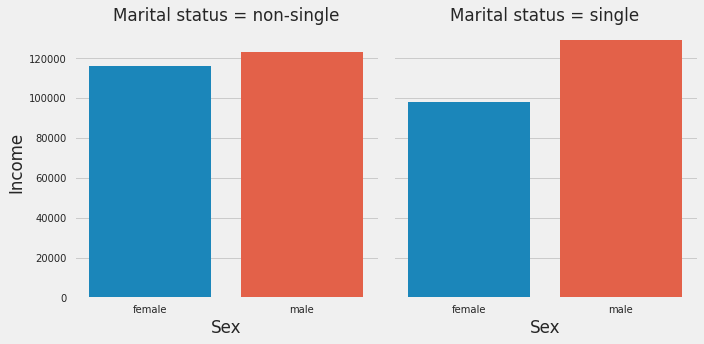

In [17]:
df = eda.groupby(by=['Sex','Marital status']).mean().reset_index()
sns.catplot(data=df,col='Marital status',x='Sex',y='Income',kind='bar',margin_titles=True);

Single male earns more than a single female by a great marigin but, the marigin is reduced for non-single male and females.

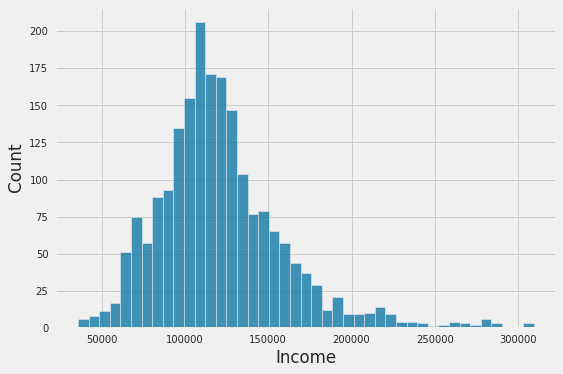

In [18]:
sns.histplot(data=eda,x='Income');

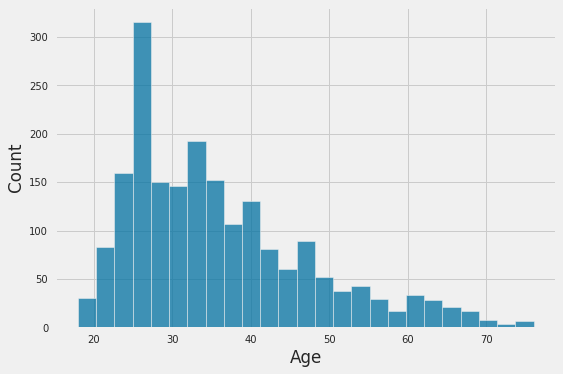

In [19]:
sns.histplot(data=eda,x='Age');

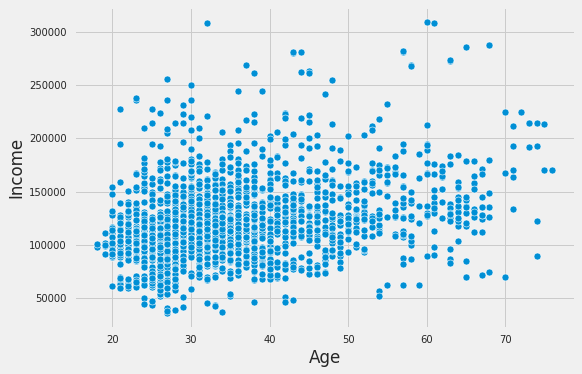

In [20]:
sns.scatterplot(data=eda,x='Age',y='Income');

### Conclusions from Exploratory Data Analysis

* The distribution of male, female & married,unmarried are fairly the same. Most of the people stop education at high school and very few go to university and even fewer go to graduate schools.
* Most people whose education background is unknown are male. Most people who go to university and graduate schools are female.
* Most people who are managers or self employed are males and most people who are employed are also male. Most people who are unemployes are female eventhough females are the ones to pursue higher education after high school.
* Least number of females live in big city and the most live in small cities. 
* Females who live in small cities are mostly unemployed and only a few self-employed live in small cities.
* non-single self-employed females earn more when compared to single females and the reverse is true for self-employed males.
* Single male earns more than a single female by a great marigin but, the marigin is reduced for non-single male and females.

# Data PreProcessing

In [21]:
data.isna().sum()

ID                 0
Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64

In [22]:
data.columns

Index(['ID', 'Sex', 'Marital status', 'Age', 'Education', 'Income',
       'Occupation', 'Settlement size'],
      dtype='object')

In [23]:
inputs = ['Sex', 'Marital status', 'Age', 'Education', 'Income',
       'Occupation', 'Settlement size']
scaler = MinMaxScaler()
data[inputs] = scaler.fit_transform(data[inputs])
data.drop('ID',axis=1,inplace=True)
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sex,2000.0,0.457000,0.498272,0.0,0.000000,0.000000,1.000000,1.0
Marital status,2000.0,0.496500,0.500113,0.0,0.000000,0.000000,1.000000,1.0
Age,2000.0,0.308776,0.202059,0.0,0.155172,0.258621,0.413793,1.0
Education,2000.0,0.346000,0.199927,0.0,0.333333,0.333333,0.333333,1.0
Income,2000.0,0.311197,0.139321,0.0,0.226048,0.291434,0.373778,1.0
Occupation,2000.0,0.405250,0.319294,0.0,0.000000,0.500000,0.500000,1.0
Settlement size,2000.0,0.369500,0.406266,0.0,0.000000,0.500000,0.500000,1.0


# Unsupervised Classsification

### Clustering Assessment

In [24]:
hopkins(scale(data),data.shape[0])

0.0704230692831164

Since the Hopkin's statistic is closer to zero, the dataset contains meaningful clusters.

### 1. KMeans Clustering

#### Selection of Optimal K

In [25]:
# to plot the elbow curve and silhouette scores
def find_k(range_n_clusters):
    ssd = []
    silhoutte_scores = []

    for num_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
        kmeans.fit(data)
        labels=kmeans.predict(data)
        silhouette = silhouette_score(data,labels)
        silhoutte_scores.append(silhouette)
        ssd.append(kmeans.inertia_)
    
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    
    axs[0].plot(ssd)
    axs[0].set_xlabel('K Value')
    axs[0].set_ylabel('Inertia')

    axs[1].plot(silhoutte_scores)
    axs[1].set_xlabel('K Value')
    axs[1].set_ylabel('Silhouette Scores')
    
    plt.tight_layout()

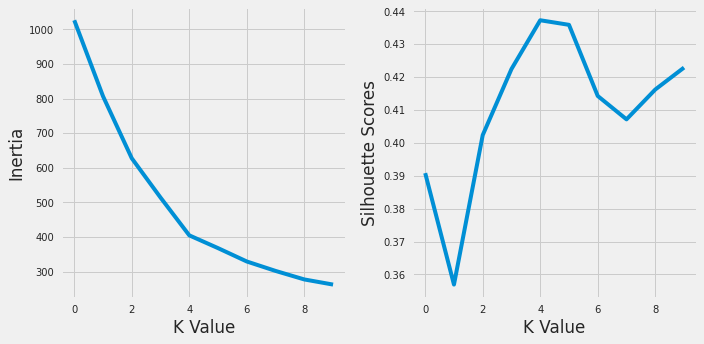

In [26]:
find_k([2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

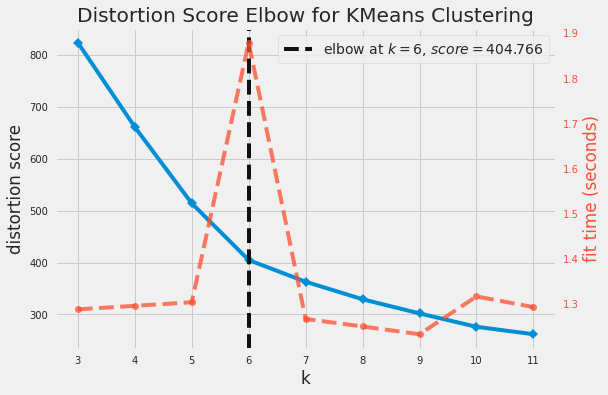

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(3,12))
visualizer.fit(data[inputs])       
visualizer.show() 

In [28]:
kmeans = KMeans(n_clusters=6,random_state=42)
kmeans.fit(data)
kmeans.cluster_centers_

array([[ 6.66133815e-16,  1.38777878e-15,  3.79443999e-01,
         2.73901809e-01,  4.00295405e-01,  6.32751938e-01,
         7.66472868e-01],
       [ 1.00000000e+00,  1.00000000e+00,  2.48556536e-01,
         4.03875969e-01,  2.42422578e-01,  2.13953488e-01,
         5.81395349e-03],
       [-4.99600361e-16,  6.10622664e-16,  3.37336124e-01,
         2.46006390e-01,  2.44762293e-01,  1.85303514e-01,
         3.03514377e-02],
       [-5.55111512e-16,  1.00000000e+00,  2.75325372e-01,
         4.22827497e-01,  3.18590599e-01,  4.66926070e-01,
         4.59143969e-01],
       [ 1.00000000e+00,  4.44089210e-16,  2.95621852e-01,
         3.10861423e-01,  2.27268625e-01,  1.85393258e-01,
         3.65168539e-02],
       [ 1.00000000e+00,  1.00000000e+00,  2.80764030e-01,
         4.44444444e-01,  3.68164246e-01,  5.91503268e-01,
         6.76470588e-01]])

In [29]:
preds = kmeans.predict(data)
preds

array([0, 5, 2, ..., 2, 1, 2], dtype=int32)

#### Clustering Evaluation

In [30]:
silhouette_score(data,preds)

0.4373042442245209

Since the score is not negative, it is a decent classification.

#### Visualization of Clusters

In [31]:
data['class'] = preds

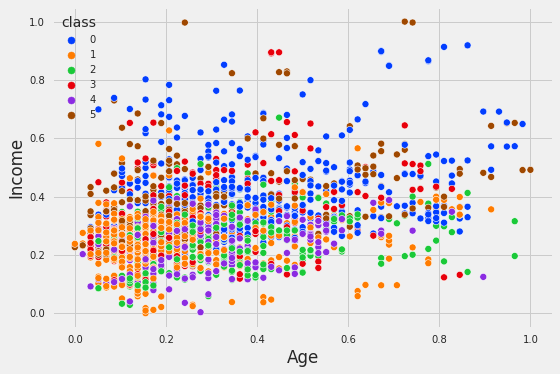

In [32]:
sns.scatterplot(data=data,x='Age',y='Income',hue='class',palette='bright');

### 2. Agglomerative Clustering

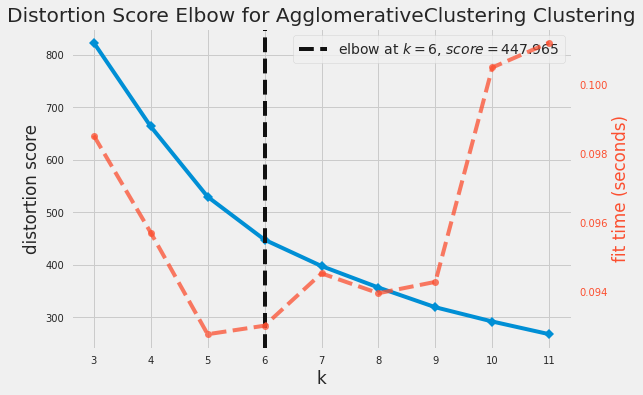

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [33]:
agg = AgglomerativeClustering()
visualizer = KElbowVisualizer(agg, k=(3,12))
visualizer.fit(data[inputs])       
visualizer.show() 

In [34]:
agg = AgglomerativeClustering(n_clusters=6)
agg_preds = agg.fit_predict(data)

In [35]:
data['agg_class'] = agg_preds

In [36]:
silhouette_score(data,agg_preds)

0.7673986765347571

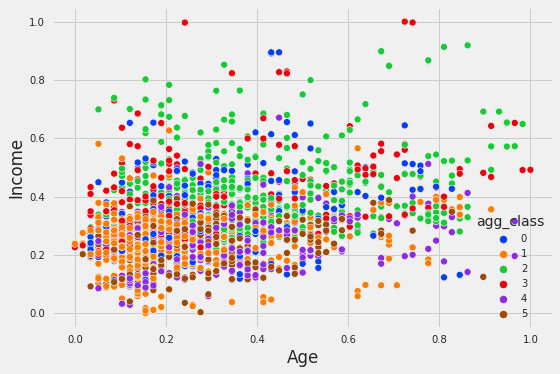

In [37]:
sns.scatterplot(data=data,x='Age',y='Income', hue='agg_class',palette='bright');